In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from typing import List


<h1> Task 1 </h1>

In [4]:
import pandas as pd
import torch

df_train = pd.read_csv('./sign_mnist_train.csv')
df_test = pd.read_csv("./sign_mnist_test.csv")

X_train, y_train = df_train.iloc[:,1:].values/255.0, df_train.iloc[:,0].values #normalizing takes place here
X_test, y_test = df_test.iloc[:,1:].values/255.0, df_test.iloc[:,0].values

value_counts = {value: np.count_nonzero(y_train == value) for value in range(-1, 31)}

print(value_counts)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer() #One hot encoding of the labels
# y_train = lb.fit_transform(y_train)
# y_test = lb.fit_transform(y_test)

print("X_train numpy shape: "+ str(X_train.shape))
print("X_test numpy shape: " +str(X_test.shape))
print("y_train numpy shape: " +str(y_train.shape))
print("y_test numpy shape: " + str(y_test.shape))


X_train_tensor, y_train_tensor = torch.tensor(X_train, dtype=torch.float).reshape(-1, 1, 28, 28), torch.tensor(y_train, dtype=torch.long) #Reshaped to 2D images for the CNN
X_test_tensor, y_test_tensor = torch.tensor(X_test, dtype=torch.float).reshape(-1,1,28,28), torch.tensor(y_test, dtype=torch.long)

print("X_train tensor shape: "+ str(X_train_tensor.shape))
print("X_test tensor shape: " +str(X_test_tensor.shape))
print("y_train tensor shape: " +str(y_train_tensor.shape))
print("y_test tensor shape: " + str(y_test_tensor.shape))


{-1: 0, 0: 1126, 1: 1010, 2: 1144, 3: 1196, 4: 957, 5: 1204, 6: 1090, 7: 1013, 8: 1162, 9: 0, 10: 1114, 11: 1241, 12: 1055, 13: 1151, 14: 1196, 15: 1088, 16: 1279, 17: 1294, 18: 1199, 19: 1186, 20: 1161, 21: 1082, 22: 1225, 23: 1164, 24: 1118, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0}
X_train numpy shape: (27455, 784)
X_test numpy shape: (7172, 784)
y_train numpy shape: (27455,)
y_test numpy shape: (7172,)
X_train tensor shape: torch.Size([27455, 1, 28, 28])
X_test tensor shape: torch.Size([7172, 1, 28, 28])
y_train tensor shape: torch.Size([27455])
y_test tensor shape: torch.Size([7172])


<h1> Task 2</h1>

In [5]:
def evaluate_accuracy(y_true, predicted_probabilities):
    predicted_classes = np.argmax(predicted_probabilities, axis=1)
    correct_predictions = predicted_classes == y_true
    accuracy = np.mean(correct_predictions) 
    return accuracy

In [6]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError
    

class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)
    
    def get_params(self):
        return self.w.copy(), self.b.copy()
    
    def set_params(self, w :np.ndarray, b:np.ndarray):
        self.w = w.copy()
        self.b = b.copy()
    

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient
    
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        # Shift x by subtracting its max value from each vector in the batch
        shift_x = x - np.max(x, axis=-1, keepdims=True)
        exps = np.exp(shift_x)
        probs = exps / np.sum(exps, axis=-1, keepdims=True)
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

In [7]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def get_params(self):
        # Collect parameters from all layers that have them
        params = []
        for layer in self.layers:
            if hasattr(layer, 'get_params'):
                params.extend(layer.get_params())
        return params

    def apply_params(self, parameters):
        # Apply parameters to all layers that have them
        param_iter = iter(parameters)
        for layer in self.layers:
            if hasattr(layer, 'set_params'):
                layer.set_params(next(param_iter), next(param_iter))

    
            

In [12]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            g_avg = g.mean(axis=0)
            p -= self.lr * g_avg


class GradientDescentOptimizerWithSchedule(GradientDescentOptimizer):
    def __init__(self, net: MLP, lr: float, schedule_step: int, decay_factor: float):
        super().__init__(net, lr)
        self.schedule_step = schedule_step
        self.decay_factor = decay_factor
        self.current_step = 0

    def step(self):
        super().step()
        self.current_step += 1
        if self.current_step % self.schedule_step == 0:
            self.update_lr()

    def update_lr(self):
        self.lr *= self.decay_factor
        print(f"Updated learning rate to {self.lr}")





In [9]:
from scipy.interpolate import interp1d


###New training algorithm
def train(mlp :MLP, optimizer, data_x, data_y, num_epochs, batch_size=128, patience=5):
    
    #First split into train/validation split
    np.random.seed(13) #So that its deterministic
    val_size = int(len(data_x) * 0.2)  # For an 80/20 split
    indices = np.arange(len(data_x))
    np.random.shuffle(indices)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    # Use the indices to create training and validation sets
    x_train, y_train = data_x[train_indices], data_y[train_indices]
    x_val, y_val = data_x[val_indices], data_y[val_indices]

    losses = []

    val_every_ith_epoch = 10
    val_losses = [float('inf')]
    labels_train = np.eye(25)[y_train] #one hot encoding
    labels_val = np.eye(25)[y_val]

    best_loss = float('inf')
    no_improvement_count = 0
    best_params = None

    for epoch in tqdm(range(num_epochs)):
        #Shuffle training every epoch so we visit in different order
        permutation = np.random.permutation(len(x_train))
        x_train_shuffled = x_train[permutation]
        y_train_shuffled = labels_train[permutation]

        #Now we go through every mini batch
        batch_loss = []
        for i in range(0, len(x_train), batch_size):
            batch_x = x_train_shuffled[i:i+batch_size]
            batch_y = y_train_shuffled[i:i+batch_size]

            predictions = mlp.forward(batch_x)
            loss = -(batch_y*np.log(predictions+1e-9)).sum(axis=-1).mean() #we take mean so loss is independent of batch size?
            batch_loss.append(loss)

            mlp.backward(batch_y)
            optimizer.step()
        losses.append(np.mean(batch_loss))

        #Validation check
        if epoch % val_every_ith_epoch == 0:
            predictions_val = mlp.forward(x_val)
            loss_val = -(labels_val * np.log(predictions_val + 1e-9)).sum(axis=-1).mean()
            if loss_val< np.min(val_losses):
                best_params = mlp.get_params()
            val_losses.append(loss_val)

        #Early stopping check
        if len(losses) > 2*patience:
            if not check_improvement(losses, patience, best_loss):
                no_improvement_count+=1
                if no_improvement_count>2:
                    print(f"Early stopping at epoch {epoch}: no improvement in the last {patience} checks.")
                    break
            else:
                no_improvement_count = 0
    
    return best_params, losses, val_losses
    
    
def check_improvement(losses, patience, best_loss):
    recent_avg_loss = np.mean(losses[-patience:])
    prev_avg_loss = np.mean(losses[-2*patience:-patience])
    if recent_avg_loss<best_loss:
        best_loss = recent_avg_loss
        return True
    return recent_avg_loss < prev_avg_loss


def plot_losses(losses, val_losses):
    if len(val_losses) > 0 and (np.isinf(val_losses[0]) or np.isnan(val_losses[0])):
        val_losses = val_losses[1:]  # We eliminate the first value since it's infinite or NaN
    
    total_epochs = len(losses)
    
    # Original epochs for validation losses
    original_val_epochs = np.linspace(1, total_epochs, len(val_losses), endpoint=True)
    
    # Interpolation for validation losses to match the total_epochs
    interp = interp1d(original_val_epochs, val_losses, kind='linear')
    interpolated_val_epochs = np.linspace(1, total_epochs, total_epochs, endpoint=True)
    interpolated_val_losses = interp(interpolated_val_epochs)
    
    plt.plot(range(1, total_epochs + 1), losses, label='Training Loss', linestyle='-', color='blue')
    plt.plot(interpolated_val_epochs, interpolated_val_losses, label='Validation Loss', linestyle='--', color='orange')
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")  # Using logarithmic scale for better visibility if losses vary widely
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.show()
    

In [10]:
def get_accuracy_stats(mlp :MLP, best_params_no_val, best_params_val, X_test, y_test, X_train, y_train):
    mlp.apply_params(best_params_no_val)
    accuracy_no_val_train = evaluate_accuracy(y_train, mlp.forward(X_train))*100
    accuracy_no_val_test = evaluate_accuracy(y_test, mlp.forward(X_test))*100

    mlp.apply_params(best_params_val)
    accuracy_val_train = evaluate_accuracy(y_train, mlp.forward(X_train))*100
    accuracy_val_test = evaluate_accuracy(y_test, mlp.forward(X_test))*100

    print(f"Train accuracy no validation = {accuracy_no_val_train:.2f}%")
    print(f"Test accuracy no validation = {accuracy_no_val_test:.2f}%")
    print(f"Train accuracy with validation = {accuracy_val_train:.2f}%")
    print(f"Test accuracy with validation = {accuracy_val_test:.2f}%")
    return accuracy_no_val_train,accuracy_no_val_test,accuracy_val_train, accuracy_val_test


<h1>TODO: Write method that checks validity of MLP model gradient (bottom of task 2)</h1>

<h1>Task 3.1</h1>

<h3> No hidden layer </h3>

In [30]:
mlp_no_hidden_layer = MLP(
    LinearLayer(784, 25),
    SoftmaxOutputLayer()
)
optimizer = GradientDescentOptimizer(mlp_no_hidden_layer, 1e-1)
gradient_steps = 200
best_val_params, train_losses, val_losses = train(mlp_no_hidden_layer, optimizer, X_train, y_train, gradient_steps)
best_no_val_params = mlp_no_hidden_layer.get_params()

100%|██████████| 200/200 [05:30<00:00,  1.65s/it]


NO HIDDEN LAYER


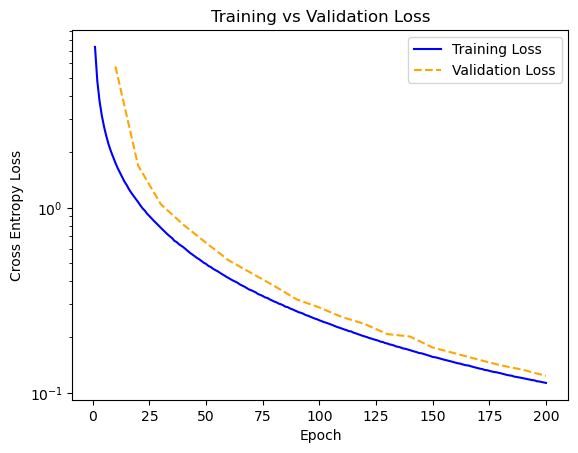

Train accuracy no validation = 99.51%
Test accuracy no validation = 63.68%
Train accuracy with validation = 99.42%
Test accuracy with validation = 64.40%







In [31]:
print("NO HIDDEN LAYER")
plot_losses(train_losses, val_losses)
no_hidden_layer_stats = get_accuracy_stats(mlp_no_hidden_layer, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)
print("\n\n\n\n")

<h3> One Hidden Layer </h3>

In [1]:
#Hyperparameter optimization

"""We might be able to use the scikit-learn MLP implementation to find out which model parameters are ideal.
In this way, we perform a grid search of all possible combinations, and then we basically report the one that's the best. Then, using the best
model structure from the scikit-learn MLP implementation, we can train our MLP implementation and see if the accuracy is similar.

We can also try and have our MLP implementation implement all the method required when passed to GridSearchCV so that GridSearchCV can be used
directly with out MLP implementation.
"""


from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (256,)],  # Single layer with varying sizes
    'learning_rate_init': [0.001, 0.01, 0.1, 1]
}

#No regularization alpha = 0.0
scimlp = MLPClassifier(activation='relu', solver='sgd', alpha=0.0, batch_size=128, max_iter=200)
grid_search = GridSearchCV(scimlp, param_grid, cv=5, verbose=2)  #cv is K-fold cross validation, verbose is amount of detail printed to console
grid_search.fit(X_train, y_train)




NameError: name 'X_train' is not defined

In [19]:
HIDDEN_UNITS = 32
mlp_one_hidden_layer_32 = MLP(
    LinearLayer(784, HIDDEN_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_UNITS, 25),
    SoftmaxOutputLayer()
)
optimizer = GradientDescentOptimizer(mlp_one_hidden_layer_32, 1e-1)
gradient_steps = 300
best_val_params_32, training_losses_32, validation_losses_32 = train(mlp_one_hidden_layer_32, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_32 = mlp_one_hidden_layer_32.get_params()


  1%|          | 3/300 [00:08<13:51,  2.80s/it]


KeyboardInterrupt: 

In [ ]:
print("ONE HIDDEN LAYER 32")
plot_losses(training_losses_32, validation_losses_32)
one_hidden_layer_stats = get_accuracy_stats(mlp_one_hidden_layer_32, best_no_val_params_32, best_val_params_32, X_test, y_test, X_train, y_train)



In [ ]:
HIDDEN_UNITS = 64
mlp_one_hidden_layer_64 = MLP(
    LinearLayer(784, HIDDEN_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_UNITS, 25),
    SoftmaxOutputLayer()
)
optimizer = GradientDescentOptimizer(mlp_one_hidden_layer_64, 1e-1)
gradient_steps = 200
best_val_params_64, training_losses_64, validation_losses_64 = train(mlp_one_hidden_layer_64, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_64 = mlp_one_hidden_layer_64.get_params()

In [ ]:
print("ONE HIDDEN LAYER 64")
plot_losses(training_losses_64, validation_losses_64)
one_hidden_layer_stats = get_accuracy_stats(mlp_one_hidden_layer_64, best_no_val_params_64, best_val_params_64, X_test, y_test, X_train, y_train)


In [ ]:
HIDDEN_UNITS = 128
mlp_one_hidden_layer_128 = MLP(
    LinearLayer(784, HIDDEN_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_UNITS, 25),
    SoftmaxOutputLayer()
)
# optimizer = GradientDescentOptimizer(mlp_one_hidden_layer_128, 1e-1)
optimizer = GradientDescentOptimizerWithSchedule(mlp_one_hidden_layer_128, lr= 0.1, schedule_step=2000, decay_factor=0.9 )
gradient_steps = 200
best_val_params_128, training_losses_128, validation_losses_128 = train(mlp_one_hidden_layer_128, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_128 = mlp_one_hidden_layer_128.get_params()

In [ ]:
#Trying to train another 200 epochs -> highlights the convergence problem we're seeing
gradient_steps = 200
best_val_params_128 = train(mlp_one_hidden_layer_128, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_128 = mlp_one_hidden_layer_128.get_params()

In [ ]:
print("ONE HIDDEN LAYER 128")
plot_losses(training_losses_128, validation_losses_128)
one_hidden_layer_stats = get_accuracy_stats(mlp_one_hidden_layer_128, best_no_val_params_128, best_val_params_128, X_test, y_test, X_train, y_train)


In [37]:
HIDDEN_UNITS = 256
mlp_one_hidden_layer_256 = MLP(
    LinearLayer(784, HIDDEN_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_UNITS, 25),
    SoftmaxOutputLayer()
)
optimizer = GradientDescentOptimizer(mlp_one_hidden_layer_256, 1e-1)
gradient_steps = 200
best_val_params_256, training_losses_256, validation_losses_256 = train(mlp_one_hidden_layer_256, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_256 = mlp_one_hidden_layer_256.get_params()

100%|██████████| 200/200 [54:45<00:00, 16.43s/it]


ONE HIDDEN LAYER 256


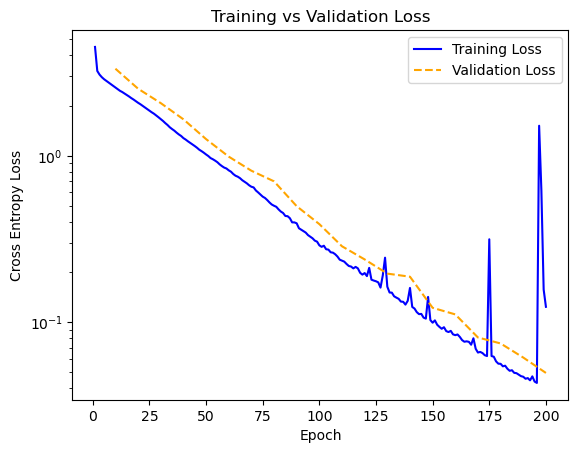

Train accuracy no validation = 97.28%
Test accuracy no validation = 58.00%
Train accuracy with validation = 99.24%
Test accuracy with validation = 57.84%


In [39]:
print("ONE HIDDEN LAYER 256")
plot_losses(training_losses_256, validation_losses_256)
one_hidden_layer_stats = get_accuracy_stats(mlp_one_hidden_layer_256, best_no_val_params_256, best_val_params_256, X_test, y_test, X_train, y_train)


In [41]:
### When its obvious that the loss is continuing to decrease, we can keep going like this:
### mlp_one_hidden_layer_256 still has the params from the last 200 epochs of training

#Training another 200 epochs
best_val_params_256_ROUND2, training_losses_256_ROUND2, validation_losses_256_ROUND2 = train(mlp_one_hidden_layer_256, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_256_ROUND2 = mlp_one_hidden_layer_256.get_params()

100%|██████████| 200/200 [54:52<00:00, 16.46s/it]


ONE HIDDEN LAYER 256 ROUND 2


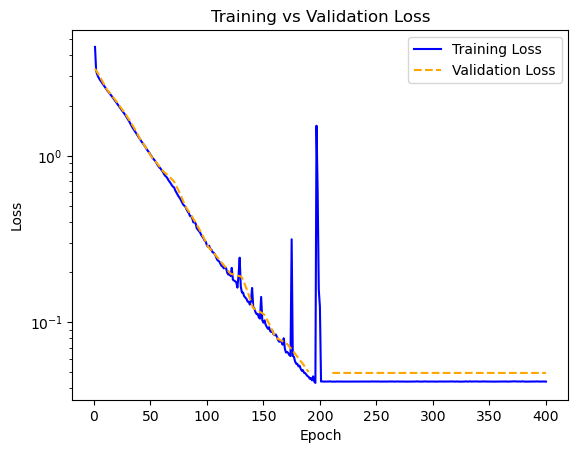

Train accuracy no validation = 99.24%
Test accuracy no validation = 57.84%
Train accuracy with validation = 99.24%
Test accuracy with validation = 57.84%


In [49]:
training_losses_256_COMBINED = training_losses_256+training_losses_256_ROUND2
validation_losses_256_COMBINED = validation_losses_256+validation_losses_256_ROUND2
print("ONE HIDDEN LAYER 256 ROUND 2")
plot_losses(training_losses_256_COMBINED, validation_losses_256_COMBINED)
one_hidden_layer_stats_ROUND2 = get_accuracy_stats(mlp_one_hidden_layer_256, best_no_val_params_256_ROUND2, best_val_params_256_ROUND2, X_test, y_test, X_train, y_train)





















.

<h3>Two Hidden Layers</h3>

In [20]:
HIDDEN_UNITS_1 = 256
HIDDEN_UNITS_2 = 256
mlp_two_32_32 = MLP(
    LinearLayer(784, HIDDEN_UNITS_1),
    ReLULayer(),
    LinearLayer(HIDDEN_UNITS_1, HIDDEN_UNITS_2),
    ReLULayer(),
    LinearLayer(HIDDEN_UNITS_2, 25),
    SoftmaxOutputLayer()
)

optimizer = GradientDescentOptimizer(mlp_two_32_32, 1e-2)
gradient_steps = 300
best_val_params_32_32, training_losses_32_32, validation_losses_32_32 = train(mlp_two_32_32, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_32_32 = mlp_two_32_32.get_params()

  1%|▏         | 4/300 [01:39<2:02:25, 24.81s/it]


KeyboardInterrupt: 

ONE HIDDEN LAYER 32 32


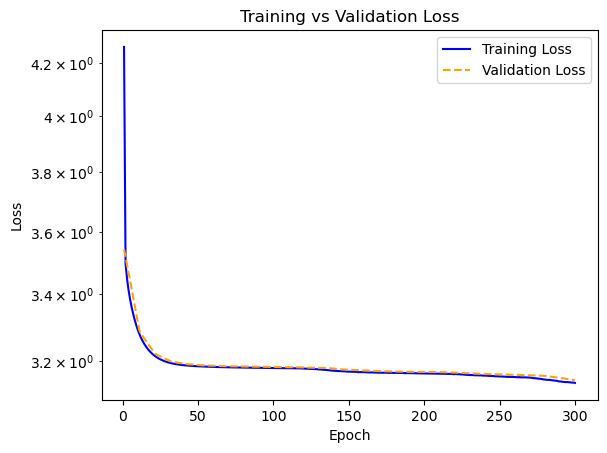

Train accuracy no validation = 6.04%
Test accuracy no validation = 2.94%
Train accuracy with validation = 6.04%
Test accuracy with validation = 2.94%


In [18]:
print("ONE HIDDEN LAYER 32 32")
#Looks bad because not enough parameters probably
plot_losses(training_losses_32_32, validation_losses_32_32)
two_32_32_stats = get_accuracy_stats(mlp_two_32_32, best_no_val_params_32_32, best_no_val_params_32_32, X_test, y_test, X_train, y_train)

In [ ]:
#TODO Continue the testing....

"













"

<h1> Task 3.2 - Sigmoid and Leaky ReLU</h1>

In [ ]:
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self, negative_slope=0.1): #Same terminology as the pytorch documentation: https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html
        super().__init__()
        self.negative_slope = negative_slope
    
    def forward(self, x):
        self.gradient = np.where(x>0, 1.0, self.negative_slope)
        return np.where(x>0.0, x, self.negative_slope*x)
    
    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

class SigmoidLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.output = None

    def forward(self, x):
        self.output = 1/(1+np.exp(-x))
        #Gradient can conveniently be expressed as sigmoid(x)*(1-sigmoid(x)), ie. self.output*(1-self.output)
        self.gradient = self.output*(1-self.output)
        return self.output
    
    def backward(self, gradient):
        assert self.output is not None, "Must call forward before backward"
        return gradient * self.gradient

<h3> Leaky ReLU </h3>

In [ ]:
#Example model, choose params based on testing
HIDDEN_UNITS_1 = None
HIDDEN_UNITS_2 = None
mlp_leaky = MLP(
     LinearLayer(784, HIDDEN_UNITS_1),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_UNITS_1, HIDDEN_UNITS_2),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_UNITS_2, 25),
    SoftmaxOutputLayer()
)
optimizer = GradientDescentOptimizer(mlp_leaky, 1e-1)
gradient_steps = 200
best_val_params_leaky, training_losses_leaky, validation_losses_leaky = train(mlp_leaky, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_leaky = mlp_leaky.get_params()

In [ ]:
print("LEAKY RELU")
plot_losses(training_losses_leaky, validation_losses_leaky)
leaky_stats = get_accuracy_stats(mlp_leaky, best_no_val_params_leaky, best_val_params_leaky, X_test, y_test, X_train, y_train)

<h3> Sigmoid Activation </h3>

In [ ]:
#Example Model, choose params based on testing
HIDDEN_UNITS_1 = None
HIDDEN_UNITS_2 = None
mlp_sigmoid = MLP(
     LinearLayer(784, HIDDEN_UNITS_1),
    SigmoidLayer(),
    LinearLayer(HIDDEN_UNITS_1, HIDDEN_UNITS_2),
    SigmoidLayer(),
    LinearLayer(HIDDEN_UNITS_2, 25),
    SoftmaxOutputLayer()
)
optimizer = GradientDescentOptimizer(mlp_sigmoid, 1e-1)
gradient_steps = 200
best_val_params_sigmoid, training_losses_sigmoid, validation_losses_sigmoid = train(mlp_sigmoid, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_sigmoid = mlp_sigmoid.get_params()

In [ ]:
print("SIGMOID ACTIVATION")
plot_losses(training_losses_sigmoid, validation_losses_sigmoid)
sigmoid_stats = get_accuracy_stats(mlp_sigmoid, best_no_val_params_sigmoid, best_val_params_sigmoid, X_test, y_test, X_train, y_train)

<h1> Task 3.3 </h1>
<h3> TODO Implement the regularization. Shouldn't affect forward pass, but backwards pass changes bc the cost function changes"

<h1>Task 3.4 </h1>

Using existing libraries such as Keras/TensorFlow or PyTorch, create a Convolutional
Neural Network (ConvNet) with 3 convolutional and 2 fully connected layers. You are free
in your choice of the hyperparameters of the convolutional layers. Experiment again with
using {32,64,128,256} hidden units in the fully connected layers and choose the best one.
Also, set the activations in all of the layers to be ReLU. Train this ConvNet on the Sign
Language MNIST dataset. Does using a ConvNet increase/decrease the accuracy compared to using MLPs? Provide comments on your results.

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, number_of_hidden_units):
        super(ConvNet, self).__init__()

        #convolution -> input image is 28x28x1 (Width x Depth x Channels)
        #output dimensions = (xh + 2ph - fh + 1) x (xw + 2pw - fw +1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) #output -> (28 + 2*1 - 3 + 1) = 28x28x32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) #output -> 28x28x64
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) #output -> 28x28x128

        #At this point if we flatten the image to vector representation for the linear layer, our input dimension would be 28*28*128=100,352 which is insanely large
        #We can apply max pooling, but we haven't really seen it in class I don't think unless I'm just behind on lectures
        #Its really quite simple, and because of the autograd provided by pytorch we don't have to think too hard about the math

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #Applying this effectively halves both the width and the height -> a 2x2 square in the orginal image is pooled to only the maximum value so 2x2 becomes 1. Stride of two allows this to never overlap

        #if we anticipate applying max pooling after conv1 then that yields 14x14x32
        #if we apply it after conv2 then that yields 7x7x64
        #So our input to the linear fully connected layers is 7x7x128 (after convolution 3) -> 128 separate 7x7 images (Feature maps)
        self.fc1 = nn.Linear(128*7*7, number_of_hidden_units)
        self.fc2 = nn.Linear(number_of_hidden_units, 25) #25 output units as previous (25 classes->really only 24 because there's a 0 examples of J and z is just chopped off the end)
    
    def forward(self, x, apply_softmax = False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x= self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)

        #Now we need to flatten the image to a vector representation
        x = x.view(-1, 7*7*128) #-1 allows pytorch to infer the size (batch dimension), 7x7x128 is as discussed above

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        if apply_softmax: #We only apply softmax if we need to, nn.CrossEntropyLoss does this internally for efficiency. So we will call forward(x, True) when we want probabilities instead of logits
            x = F.softmax(x, dim=1)

        return x

In [64]:
from torch.utils.data import TensorDataset, DataLoader, random_split

full_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

val_size = int(len(X_train_tensor)*0.2) #80:20 split
train_size = len(X_train_tensor)-val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



number_of_hidden_units_TORCH = 64 #To change


In [63]:
import torch.optim as optim

conv_net = ConvNet(number_of_hidden_units=number_of_hidden_units_TORCH).float()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
conv_net.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(), lr = 0.001)

train_losses = []
val_losses = []

num_epochs = 300
for epoch in range(num_epochs):

    conv_net.train()
    train_loss = 0.0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = conv_net(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    conv_net.eval()
    val_loss = 0.0
    with torch.nograd():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = conv_net(images)
            loss = loss_function(outputs, labels)
            val_loss+=loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# We can save the model parameters as a .pth file
model_path = 'conv_net_params.pth'
torch.save(conv_net.state_dict(), model_path)

plot_losses(train_losses.numpy(), val_losses.numpy())

Epoch [1/300], Loss: 0.5024
Epoch [2/300], Loss: 0.0448
Epoch [3/300], Loss: 0.0204
Epoch [4/300], Loss: 0.0262
Epoch [5/300], Loss: 0.0072
Epoch [6/300], Loss: 0.0006
Epoch [7/300], Loss: 0.0005
Epoch [8/300], Loss: 0.0011
Epoch [9/300], Loss: 0.0060
Epoch [10/300], Loss: 0.0004
Epoch [11/300], Loss: 0.0012
Epoch [12/300], Loss: 0.0002
Epoch [13/300], Loss: 0.0001
Epoch [14/300], Loss: 0.0001
Epoch [15/300], Loss: 0.0001
Epoch [16/300], Loss: 0.0002
Epoch [17/300], Loss: 0.0001
Epoch [18/300], Loss: 0.0002
Epoch [19/300], Loss: 0.0001
Epoch [20/300], Loss: 0.0000
Epoch [21/300], Loss: 0.0000
Epoch [22/300], Loss: 0.0000
Epoch [23/300], Loss: 0.0001
Epoch [24/300], Loss: 0.0000
Epoch [25/300], Loss: 0.0000
Epoch [26/300], Loss: 0.0000
Epoch [27/300], Loss: 0.0000
Epoch [28/300], Loss: 0.0000
Epoch [29/300], Loss: 0.0000
Epoch [30/300], Loss: 0.0000
Epoch [31/300], Loss: 0.0000
Epoch [32/300], Loss: 0.0000
Epoch [33/300], Loss: 0.0000
Epoch [34/300], Loss: 0.0000
Epoch [35/300], Loss: 0

KeyboardInterrupt: 

In [60]:
def get_accuracy_stats_TORCH(model : ConvNet, params_path, X_test:torch.tensor, y_test:torch.tensor, X_train:torch.tensor, y_train:torch.tensor):
    model.load_state_dict(torch.load(params_path))
    model.eval() #faster

    device = torch.device("cpu")
    model.to(device)
    X_test=X_test.to(device)
    y_test=y_test.to(device)
    X_train=X_train.to(device)
    y_train=y_train.to(device)

    with torch.no_grad():
        probabilities_test = model.forward(X_test, apply_softmax=True)
        test_accuracy = evaluate_accuracy(y_test.numpy(), probabilities_test.numpy())*100
        probabilities_train = model.forward(X_train, apply_softmax=True)
        train_accuracy = evaluate_accuracy(y_train.numpy(), probabilities_train.numpy())*100
    
    print(f"Train accuracy = {train_accuracy:.2f}%")
    print(f"Test accuracy = {test_accuracy:.2f}%")
    return train_accuracy, test_accuracy

In [61]:
get_accuracy_stats_TORCH(conv_net, model_path, X_test_tensor, y_test_tensor, X_train_tensor, y_train_tensor)

Train accuracy = 100.00%
Test accuracy = 90.84%


(100.0, 90.8393753485778)